# Adversarial attacks and adversarial training

## Introduction

It is well known that *adversarial attacks* can make state-of-the art classifiers to consistently fail based on a optimization procedure that maximises its prediction error by slightly changing a data point such that it is related to a very different class (Szegedy 2014; Goodfellow 2014). Some of these image manipulations are so small at each pixel that are not distinguisable by eye and are consistent across different architectures and trained on different sets of examples. 

Goodfellow showed that these adversarial examples could be explained by an excessive linearity of the mapping from the input to the output of the model, where neural networks (NN) can be considered as piecewise constant (Goodfellow 2014). We note that the map from parameters of the NN to the output is nonlinear: this makes problems optimizing on the input of the model easier than fitting the model parameters. NN are not the only models sensitive to these type of attacks, as other models such as logistic regression, linear SVMs, decision trees, and neareast neighbors failed to these adversarial attacks in a similar way (Goodfellow, 2017). The facts that different methods lead to similar misclassification with the same adversarial examples can be explained by the hypothesis that they are learning similar linear classifiers (Goodfellow 2014).

These results go against previous assumptions on neural nets. It has been assumed that NNs constitute *non-local generalization priors* over the input space. In this case, regions of the space with no training examples will get low probabilities. Let $x\in\mathbb{R}^p$ be an image and $r$ a small perturbation with $\|r\|<\epsilon$, *local* generalizations will make perturbed examples $x+r$ to get assigned the same class as $x$ (Szegedy 2014). Finding adversarial examples shows that this smoothness assumption does not hold and that the manifold represented by the network can be crossed using optimization, finding adversarial examples. Training with a cross entropy loss can be explained by learning the conditional probability of a class given an input. Then, adversarial examples lie in low-probability regions of the manifold. This also goes against the tendency of using CNNs for feature representation where Euclidean distance approximates perceptual distance, as images with small perceptual distance can lead to completely different classes.

On the other hand, *adversarial training* can alter this linear behavior by encouraging locally constant behavior when making it robust to these perturbations. Thus, adversarial training may improve 
generalization and can provide regularization effects further different to those of dropout (Goodfellow 2014). This is motivated by the fact that natural images classes lie on disconnected manifolds. When classes are well separated, we expect that a classifier will assign the same class to two inputs $x$ and $\tilde{x}$ as long as $\|x-\tilde{x}\|_{\infty}$. 

This type of augmented data training is different to the commonly input transformations, which are highly correlated and belong to the same probability distribution. A point in favor of NN is that while adversarial examples affect linear methods and other methods such as nearest neighbors, NN can learn any nonlinear function and can be trained to resist these attacks. However, shallow networks can not be fit to be constant around training points (Goodfellow 2014).

Recent theoretical works aim at understanding the origin of adversarial examples and the effect of adversarial training. (Allen-Zhu 2020) shows that learning leads to an accumulation of small mixtures of the hidden weights, as gradient descent updates are highly correlated, and that adversarial training purifies this weights  affecting the learned features, making them to resemble more the original image space. 

Adversarial training at pretraining and fine-tuning stages, in combination with adversarial perturbation of the embedidng space (image features), has bee proposed for large scale boosting performance for vision and language applications (Gan 2020). 

In this repository, we explore several adversarial attack methods and their effect on misclassification. This repository example is based on the following resources: 

* Keras adversarial example using FGSM, https://www.tensorflow.org/tutorials/generative/adversarial_fgsm
* Lecture 16 - Adversarial Examples and Adversarial Training, 
Stanford University School of Engineering, 2017. https://www.youtube.com/watch?v=CIfsB_EYsVI

## Notebook set-up

### Dependencies

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from tensorflow import keras 

### Mount google drive and paths

Start by mounting your google drive:   

In [2]:
# Mount google drive to access files via colab
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Path to the script model /content/gdrive/MyDrive/Colab_Notebooks/deep-learning-for-computer-vision-with-keras

In [3]:
# path notebook
path_notebook = '/content/gdrive/MyDrive/Colab_Notebooks/deep-learning-for-computer-vision-with-keras'
os.chdir(path_notebook)
print('Current directory: ' + os.getcwd())

Current directory: /content/gdrive/MyDrive/Colab_Notebooks/deep-learning-for-computer-vision-with-keras


## Load model and classify

Load pretrained keras model MobileNetV2 (Sandler 2018), trained on ImageNet, and ImageNet labels: 

In [4]:
# Pretrained model
model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
# Freeze wights
model.trainable = False

# ImageNet probs to class and confidence
# _, image_class, class_confidence = decode_predictions(probs, top=1)[0][0]
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14540800/14536120 [==============================] - 0s 0us/step


Define preprocessing, labeling and displaying functions as defined in https://www.tensorflow.org/tutorials/generative/adversarial_fgsm

In [5]:
# Preprocess the image for MobileNetV2: Resize and normalize
def preprocess(image):
  # tf.uint8 -> tf.float32
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  # Normalize to [-1,1]
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Get predicted probability output
def get_imagenet_label(probs):
  # Return 1 prediction from (1, 1000) vector of probabilities
  return decode_predictions(probs, top=1)[0][0]

# Display image and classification output
def display_img_prediction(image, probs):
  # image tf tensor [1, 224, 224, 3]
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  _, image_class, class_confidence = get_imagenet_label(probs)
  result = '{} : {:.2f}% Confidence'.format(image_class, class_confidence*100)
  print(result)
  plt.title(result)
  plt.show()

def normalize_back_img(img):
  # Normalize from [-1,1] to [0,255]
  return 255*(img + 1)/2   

Load image example and preprocess it

In [6]:
# Download image
test_image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
test_image_raw = tf.io.read_file(test_image_path)
test_image = tf.image.decode_image(test_image_raw)

# Cast to float, reshape and normalizes to [-1, 1]
test_image = preprocess(test_image)

90112/83281 [================================] - 0s 0us/step


Classify test image and display result

40960/35363 [==================================] - 0s 0us/step
Labrador_retriever : 41.82% Confidence


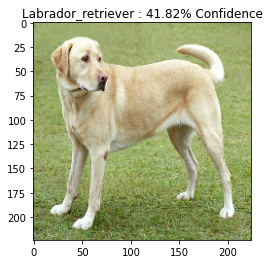

In [7]:
# Predict
test_pred = model.predict(test_image)
_, test_pred_class, test_class_confidence = get_imagenet_label(test_pred)
display_img_prediction(test_image, test_pred)

## Adversarial attacks

### Adversarial attack using FGSM method

Adversarial attacks solve the following optimization problem:

$$
\min f(x+r)=l \quad \textrm{s.t.} \quad (x+r)\in D,
$$

where $f$ is the classifier, $x$ is th input image and $x$ is a perturbation that makes the adversarial example $x+r$ to be incorrectly classified as $l\neq h(x)$. 

Fast gradient sign method (FGSM) solves the previous problem by taking an step along the gradient of the cost function of the classifier $J$ with respect to the input image: 

$$
\tilde{x}=x+\epsilon \textrm{sign}(\nabla_x J(x,y_{\textrm{true}})). 
$$

Given the weights vector $w$ and a perturbation defined as $r=\textrm{sign}(w)$ for $w^T\tilde{x}=w^Tx+w^Tr$,  the *sign* function maximizes the perturbation while ensuring the constraint $\|r\|_{\infty}\leq\epsilon$. If $x$ has $p$ dimensions and the elements of $w$ have an average value of $m$, then the changes in the activation $w^Tr$ can grow linearly with $p$ and as much as $\epsilon pm$. Thus, high-dimensional linear models are vulnerable to adversarial examples and NNs are 'too linear to resist linear adversarial pertubation' (Goodfellow 2014). 

To compute the adversarial perturbation $r$, we define the loss $J$ and compute its gradient $\nabla_x J$ wrt the input image $x$ and its label $y_{\textrm{true}}$.

In [9]:
# Define the loss
loss_object = tf.keras.losses.CategoricalCrossentropy()

In [11]:
def adversarial_perturbation(img, label):
  # Compute the gradient of the loss wrt the input image
  with tf.GradientTape() as tape:
    tape.watch(img)
    img_pred = model(img)
    loss = loss_object(label, img_pred)
  gradient = tape.gradient(loss, img)

  # Create perturbation as the gradient sign 
  gradient_sign = tf.sign(gradient)
  return gradient_sign

In [12]:
# One hot labels vector (1,1000)
test_image_index = 208
num_classes = test_pred.shape[-1]
test_one_hot_label = tf.one_hot(test_image_index, num_classes)
test_one_hot_label = tf.reshape(test_one_hot_label, (1, num_classes))

# Create adversarial perturbation
img_perturbation = adversarial_perturbation(test_image, test_one_hot_label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Adversarial perturbation')

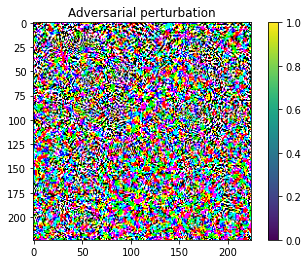

In [13]:
# Display the perturbation
plt.imshow(img_perturbation[0])
plt.colorbar()
plt.title('Adversarial perturbation')

Advesarial attacks where no pixel is perturbed in more than $1$, ie. $|r_i|\leq 1$.

In [14]:
def normalize_back_img(img):
  # Normalize from [-1,1] to [0,255]
  return 255*(img + 1)/2   

In [29]:
# Adversarial attack
def adversarial_attack(img,img_perturbation, eps=0.9):
  img_adversarial = (normalize_back_img(img) + eps*img_perturbation) + eps
  img_adversarial = 255*img_adversarial/np.max(img_adversarial)
  return img_adversarial

test_adversarial = adversarial_attack(test_image,img_perturbation, eps=0.9)

Display the adversarial corrupted image and classify it, providing a confidence value.

Saluki : 11.57% Confidence


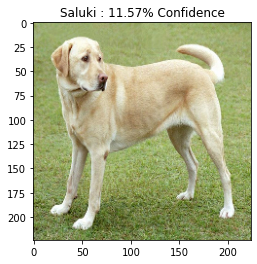

In [30]:
# Process image as required by the model
test_adversarial = preprocess(test_adversarial[0])
# Predict probabilities for each class
test_adversarial_pred = model.predict(test_adversarial)
# Class and confidence
_, test_adversarial_class, test_adversarial_class_confidence = get_imagenet_label(test_adversarial_pred)
# Display
display_img_prediction(test_adversarial, test_adversarial_pred)

Mission achieved: The classifier predicts the wrong class! However, the confidence is low!

Next we assess the effect of the size of the perturbation on misclassified responses.

In [36]:
# Size of perturbation
eps_all = np.linspace(0.001, 0.9, 30)
test_adversarial_class_all = []
test_adversarial_class_confidence_all = []
for eps in eps_all:
  # Adversarial attack
  test_adversarial = adversarial_attack(test_image,img_perturbation, eps=eps)
  test_adversarial = preprocess(test_adversarial[0])  
  test_adversarial_pred = model.predict(test_adversarial)
  _, test_adversarial_class, test_adversarial_class_confidence = get_imagenet_label(test_adversarial_pred)
  
  test_adversarial_class_all.append(test_adversarial_class)
  test_adversarial_class_confidence_all.append(test_adversarial_class_confidence)

  #print('Perturbation size %f:' %(eps) )
  #display_img_prediction(test_adversarial, test_adversarial_pred)

Text(0.5, 0, 'eps')

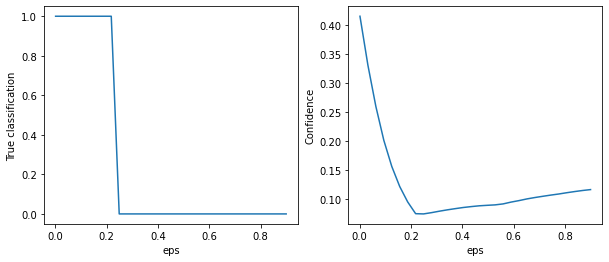

In [44]:
# Misclassifications vs eps
true_clas = [test_adversarial_class_all[i] == 'Labrador_retriever' for i in range(len(test_adversarial_class_all))]

plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(eps_all, true_clas)
plt.ylabel('True classification')
plt.xlabel('eps')
#
# Confidence vs eps
plt.subplot(1,2,2)
plt.plot(eps_all, test_adversarial_class_confidence_all)
plt.ylabel('Confidence')
plt.xlabel('eps')

The size of the perturbation must be larger than $0.25$ for the adversarial attack to be successful. However, the confidence is low, so the adversarial attack may not go unnoticed. For instance, for $0.25$ the confidence interval is only $9.27$%. 

Largest perturbations lead to higher confidence, yet they are more prone to fail. Perturbation of size $5$ leads to $48$ % confidence. 

### Target Class Method

We assess the target class method in order to obtain higher confidence values, which may make the attack to go unnoticed (Alexey Kurakin, Ian J. Goodfellow, and Samy Bengio. 2016. Adversarial Machine Learning at Scale, arXiv:1611.01236).  

It is a modification of FGSM that computes the gradient of the cost for a 'target class' instead of the input image class as in the original FGSM method: 

$$
\tilde{x}=x-\epsilon \textrm{sign}(\nabla_x J(x,y_{\textrm{target}})). 
$$

We define below the perturbation and the attack for the target method.

In [55]:
# Target method
def adversarial_perturbation_target_label(img, label_target):
  # Compute the gradient of the loss wrt the input image
  with tf.GradientTape() as tape:
    tape.watch(img)
    img_pred = model(img)
    loss = loss_object(label_target, img_pred)
  gradient = tape.gradient(loss, img)
  # Create perturbation as the gradient sign 
  gradient_sign = tf.sign(gradient)
  return gradient_sign

# Adversarial attack
def adversarial_attack_target_label(img,img_perturbation, eps=0.9):
  img_adversarial = (normalize_back_img(img) - eps*img_perturbation) + eps
  img_adversarial = 255*img_adversarial/np.max(img_adversarial)
  return img_adversarial



We need to select a target class. We have seen that selecting specific classes leads to higher confidence, as it is the case of 'Siberian husky' and 'Saluki, gazelle hound'. This could be because of the related shape and color. 

Siberian_husky : 35.94% Confidence


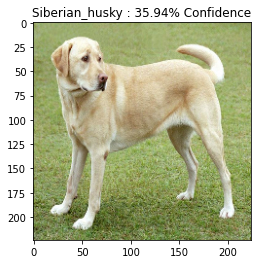

Saluki : 90.12% Confidence


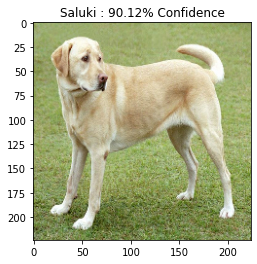

In [56]:
# Target german shepherd
# 235: 'German shepherd, German shepherd dog, German police dog, alsatian',
# 250: 'Siberian husky',
# 251: 'dalmatian, coach dog, carriage dog',
# test_one_hot_label = tf.one_hot(250, num_classes)
# 176: 'Saluki, gazelle hound',
# 290: 'jaguar, panther, Panthera onca, Felis onca',
# 250, 176
label_targets = (250, 176)
for label_target in label_targets:
  test_one_hot_label = tf.one_hot(label_target, num_classes)
  test_one_hot_label = tf.reshape(test_one_hot_label, (1, num_classes))

  # Modified adversarial attack
  img_perturbation_mod = adversarial_perturbation_target_label(test_image, test_one_hot_label)
  test_adversarial = adversarial_attack_target_label(test_image,img_perturbation_mod, eps=0.9)
  test_adversarial = preprocess(test_adversarial[0])
  test_adversarial_pred = model.predict(test_adversarial)
  _, test_adversarial_class, test_adversarial_class_confidence = get_imagenet_label(test_adversarial_pred)
  display_img_prediction(test_adversarial, test_adversarial_pred)

'Saluki, gazelle hound' with $90.12$% confidence, not bad!

### More on adversarial training

Other methods exist for creating adversarial examples. Rotating slightly the image $x$ in the direction of the previous gradient also yields adversarial examples (Goodfellow 2014). Other strategies have been proposed to counteract some of these attacks, but still none of them can mitigate all these perturbations (Chakraborty, 2018). An iterative method based on FGSM 

$$
x^0=x, \quad x^{n+1}=Clip_x(x^n+\epsilon \textrm{sign}(\nabla_x J(x,y_{\textrm{true}}))), 
$$

where clipping makes their values to belong to the interval $[x-\epsilon,x+\epsilon]$.

Another approach to *adversarial training* proposes an adversarial objective function that acts as a regularizer:

$$
\tilde{J}(w,x,y)=\alpha J(w,x,y)+(1-\alpha)J(w,x+\epsilon\textrm{sign}\nabla_x J(w,x,y),y),
$$

where $\alpha=0.5$. With this training, the error rate on adversarial examples fell from $89.4$% to $17.9$%, by using a deep network. 'Adversarial training procedure can be seen as minimizing the worst case error' (Goodfellow 2014). 

A recent result proved that adversarial training makes the model robust to similar attacks and that low complexity models such as linear classifiers are not able to defend against these attacks (Allen-Zhu 2020).

## Conclusions

We have created adversarial attacks based on the original FGSM method and the target class method. The latter can lead to higher confidence attacks.  More sophisticated adversarial attacks may be used, as methods that are computationally expensive to evaluate may be hard to use in adversarial training strategies.

## References

* Keras adversarial example using FGSM, https://www.tensorflow.org/tutorials/generative/adversarial_fgsm
* (Allen-Zhu 2020) Z Allen-Zhu and Y Li, Feature Purification: How Adversarial Training Performs Robust Deep Learning, 2020, arXiv:2005.10190v2
* (Chakraborty, 2018) A Chakraborty et al, Adversarial Attacks and Defences: A Survey, 2018
* (Gan 2020) Z Gan et al, Large-Scale Adversarial Training for
Vision-and-Language Representation Learning, 2020, arXiv:2006.06195v2
* (Goodfellow 2016) I Goodfellow et al, Deep learning (Chapter 7), MIT, 2016
* (Goodfellow 2017) I Goodfellow, Lecture 16 - Adversarial Examples and Adversarial Training, Stanford University School of Engineering, 2017. https://www.youtube.com/watch?v=CIfsB_EYsVI
* (Sandler 2018) M Sandler et al, MobileNetV2: Inverted Residuals and Linear Bottlenecks, 2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition, 2018, pp. 4510-4520.
* (Szegedy 2014) Szegedy, Christian, Zaremba, Wojciech, Sutskever, Ilya, Bruna, Joan, Erhan, Dumitru, Goodfellow, Ian J., and Fergus, Rob. Intriguing properties of neural networks. ICLR, abs/1312.6199, 2014.
